In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Construcción del Modelo

In [2]:
import torch.nn as nn
from torchinfo import summary

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        ##  ERROR AQUI
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh() # [-1,1]

        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.gen(x)

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

## Training

In [6]:
# HYPERPARAMETERS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 2e-4
BATCH_SIZE = 50
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

## Lectura de Datos

In [7]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))
    ])

c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
data = datasets.ImageFolder('data/monet', transform=transform)

Validamos que podemos leer las imágenes

c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


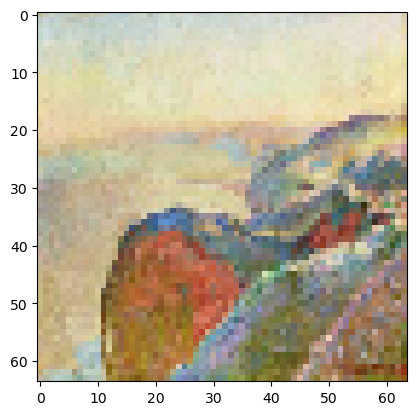

In [9]:
image, _ = data[0]
plt.imshow(image.permute(1, 2, 0))

In [10]:
# Corroboramos que el dataset tiene 300 imágenes
len(data)

300

## Split de Datos

In [11]:
def split_data(data, test_proportion):
    registers = len(data)
    test_size = int(np.round(test_proportion*registers))
    train_data, test_data = torch.utils.data.random_split(data, [registers - test_size, test_size])
    return train_data, test_data

In [12]:
train_data, test_data = split_data(data, 0.1)
len(train_data), len(test_data)

(270, 30)

## Batch de Datos

In [13]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

def load_data(data, batch_size):
    return DataLoader(data, batch_size=batch_size, shuffle=True)

In [14]:
train_loader = load_data(train_data, BATCH_SIZE)
print(f"Batch size: {BATCH_SIZE}")

Batch size: 50


In [15]:
def view_sample(tensor_img, num_images = 9, size=(3, 3)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=3)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

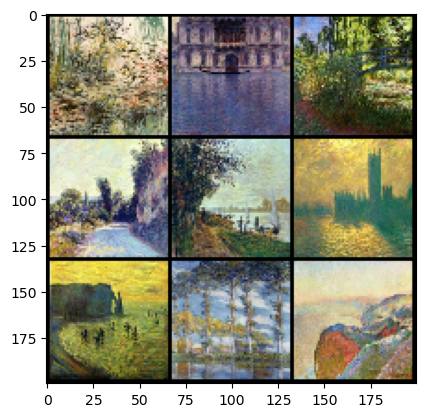

In [16]:
images, _ = next(iter(train_loader))
view_sample(images)

c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [0/100] Batch 0/6                 Loss D: 0.6927, loss G: 0.7913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


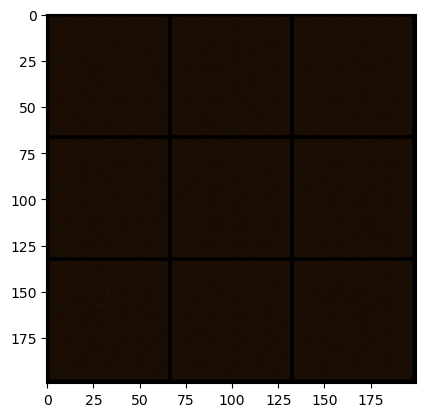

Epoch [1/100] Batch 0/6                 Loss D: 0.4724, loss G: 1.1409
Epoch [2/100] Batch 0/6                 Loss D: 0.3096, loss G: 1.4779
Epoch [3/100] Batch 0/6                 Loss D: 0.2050, loss G: 1.7841
Epoch [4/100] Batch 0/6                 Loss D: 0.1506, loss G: 2.0511
Epoch [5/100] Batch 0/6                 Loss D: 0.1135, loss G: 2.3118
Epoch [6/100] Batch 0/6                 Loss D: 0.0867, loss G: 2.5336
Epoch [7/100] Batch 0/6                 Loss D: 0.0692, loss G: 2.7455
Epoch [8/100] Batch 0/6                 Loss D: 0.0588, loss G: 2.8817
Epoch [9/100] Batch 0/6                 Loss D: 0.0493, loss G: 3.1032
Epoch [10/100] Batch 0/6                 Loss D: 0.0389, loss G: 3.2915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


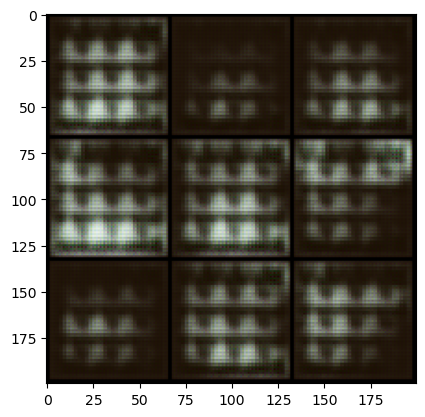

Epoch [11/100] Batch 0/6                 Loss D: 0.0337, loss G: 3.4509
Epoch [12/100] Batch 0/6                 Loss D: 0.0283, loss G: 3.5976
Epoch [13/100] Batch 0/6                 Loss D: 1.0148, loss G: 0.3369
Epoch [14/100] Batch 0/6                 Loss D: 0.6578, loss G: 0.7874
Epoch [15/100] Batch 0/6                 Loss D: 0.5686, loss G: 1.1465
Epoch [16/100] Batch 0/6                 Loss D: 0.4439, loss G: 1.4135
Epoch [17/100] Batch 0/6                 Loss D: 0.2730, loss G: 0.3783
Epoch [18/100] Batch 0/6                 Loss D: 0.5139, loss G: 1.2894
Epoch [19/100] Batch 0/6                 Loss D: 0.5579, loss G: 1.1269
Epoch [20/100] Batch 0/6                 Loss D: 0.3866, loss G: 1.8857


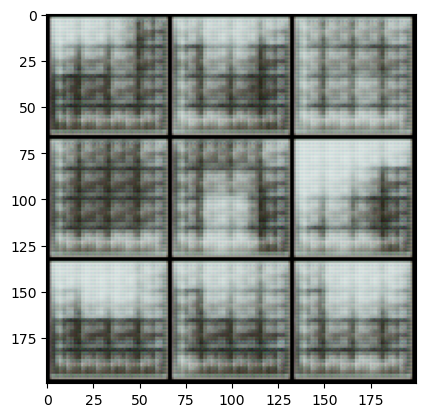

Epoch [21/100] Batch 0/6                 Loss D: 0.4064, loss G: 2.0069
Epoch [22/100] Batch 0/6                 Loss D: 0.4284, loss G: 2.4120
Epoch [23/100] Batch 0/6                 Loss D: 0.2140, loss G: 2.2091
Epoch [24/100] Batch 0/6                 Loss D: 0.1180, loss G: 2.9077
Epoch [25/100] Batch 0/6                 Loss D: 0.1678, loss G: 3.5068
Epoch [26/100] Batch 0/6                 Loss D: 0.4114, loss G: 2.3627
Epoch [27/100] Batch 0/6                 Loss D: 0.5704, loss G: 1.4881
Epoch [28/100] Batch 0/6                 Loss D: 0.2648, loss G: 2.4568
Epoch [29/100] Batch 0/6                 Loss D: 0.4781, loss G: 2.4835
Epoch [30/100] Batch 0/6                 Loss D: 0.5801, loss G: 1.2763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


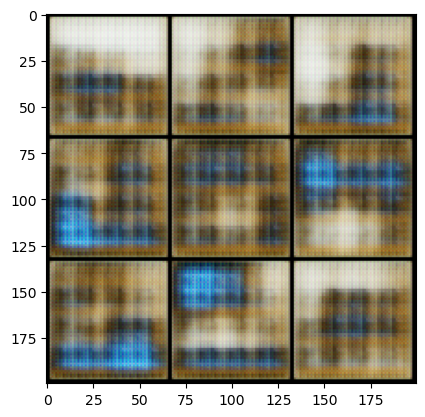

Epoch [31/100] Batch 0/6                 Loss D: 0.4430, loss G: 1.1420
Epoch [32/100] Batch 0/6                 Loss D: 0.4353, loss G: 1.4805
Epoch [33/100] Batch 0/6                 Loss D: 0.5070, loss G: 1.5134
Epoch [34/100] Batch 0/6                 Loss D: 0.4667, loss G: 2.0211
Epoch [35/100] Batch 0/6                 Loss D: 0.5448, loss G: 1.7461
Epoch [36/100] Batch 0/6                 Loss D: 0.4126, loss G: 2.4103
Epoch [37/100] Batch 0/6                 Loss D: 0.3825, loss G: 2.2346
Epoch [38/100] Batch 0/6                 Loss D: 0.5015, loss G: 2.8551
Epoch [39/100] Batch 0/6                 Loss D: 0.4320, loss G: 2.0422
Epoch [40/100] Batch 0/6                 Loss D: 0.5893, loss G: 1.9329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


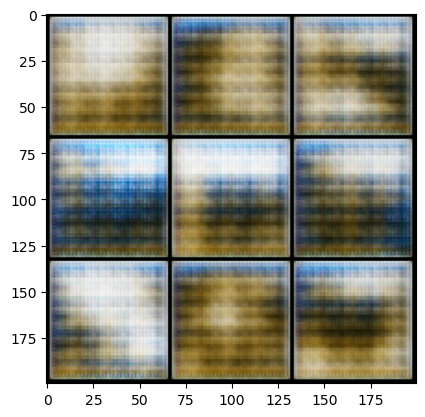

Epoch [41/100] Batch 0/6                 Loss D: 0.6333, loss G: 1.2784
Epoch [42/100] Batch 0/6                 Loss D: 0.4403, loss G: 1.5347
Epoch [43/100] Batch 0/6                 Loss D: 0.5026, loss G: 1.5049
Epoch [44/100] Batch 0/6                 Loss D: 0.5307, loss G: 1.4497
Epoch [45/100] Batch 0/6                 Loss D: 0.4808, loss G: 1.7087
Epoch [46/100] Batch 0/6                 Loss D: 0.5655, loss G: 1.7453
Epoch [47/100] Batch 0/6                 Loss D: 0.6753, loss G: 0.9648
Epoch [48/100] Batch 0/6                 Loss D: 0.5953, loss G: 1.4594
Epoch [49/100] Batch 0/6                 Loss D: 0.4029, loss G: 1.6045
Epoch [50/100] Batch 0/6                 Loss D: 0.2853, loss G: 3.5480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


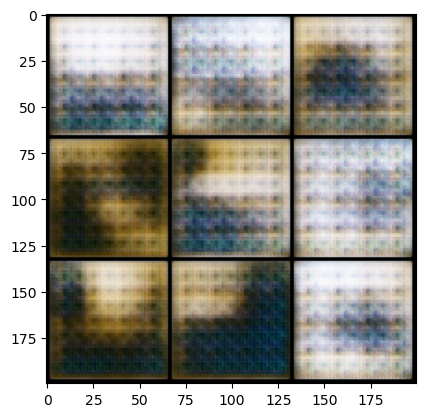

Epoch [51/100] Batch 0/6                 Loss D: 0.5125, loss G: 1.0050
Epoch [52/100] Batch 0/6                 Loss D: 0.3506, loss G: 2.3302
Epoch [53/100] Batch 0/6                 Loss D: 0.7239, loss G: 1.5449
Epoch [54/100] Batch 0/6                 Loss D: 0.5113, loss G: 1.7011
Epoch [55/100] Batch 0/6                 Loss D: 0.5290, loss G: 0.9377
Epoch [56/100] Batch 0/6                 Loss D: 0.7616, loss G: 1.1694
Epoch [57/100] Batch 0/6                 Loss D: 0.6382, loss G: 1.2914
Epoch [58/100] Batch 0/6                 Loss D: 0.5859, loss G: 1.4810
Epoch [59/100] Batch 0/6                 Loss D: 0.6148, loss G: 1.2349
Epoch [60/100] Batch 0/6                 Loss D: 0.4282, loss G: 1.6683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


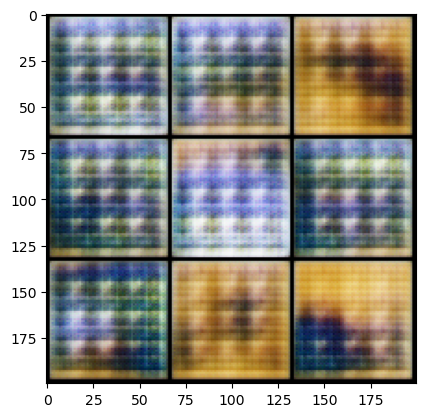

Epoch [61/100] Batch 0/6                 Loss D: 0.4858, loss G: 1.4489
Epoch [62/100] Batch 0/6                 Loss D: 0.5173, loss G: 1.3107
Epoch [63/100] Batch 0/6                 Loss D: 0.6417, loss G: 1.0823
Epoch [64/100] Batch 0/6                 Loss D: 0.6660, loss G: 1.6663
Epoch [65/100] Batch 0/6                 Loss D: 0.4308, loss G: 2.5329
Epoch [66/100] Batch 0/6                 Loss D: 0.7450, loss G: 1.6723
Epoch [67/100] Batch 0/6                 Loss D: 0.4557, loss G: 1.5906
Epoch [68/100] Batch 0/6                 Loss D: 0.4454, loss G: 0.8456
Epoch [69/100] Batch 0/6                 Loss D: 0.6003, loss G: 1.1370
Epoch [70/100] Batch 0/6                 Loss D: 0.5253, loss G: 2.4381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


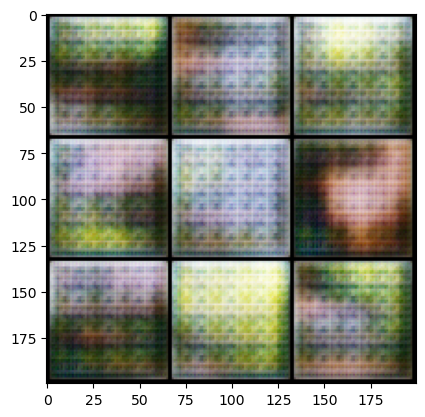

Epoch [71/100] Batch 0/6                 Loss D: 0.5907, loss G: 2.2993
Epoch [72/100] Batch 0/6                 Loss D: 0.5977, loss G: 1.0805
Epoch [73/100] Batch 0/6                 Loss D: 0.4549, loss G: 1.2828
Epoch [74/100] Batch 0/6                 Loss D: 0.6261, loss G: 1.4494
Epoch [75/100] Batch 0/6                 Loss D: 0.3306, loss G: 1.9346
Epoch [76/100] Batch 0/6                 Loss D: 0.6087, loss G: 1.5881
Epoch [77/100] Batch 0/6                 Loss D: 0.4842, loss G: 1.7147
Epoch [78/100] Batch 0/6                 Loss D: 0.5072, loss G: 1.8737
Epoch [79/100] Batch 0/6                 Loss D: 0.8432, loss G: 1.7722
Epoch [80/100] Batch 0/6                 Loss D: 0.4638, loss G: 1.5592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


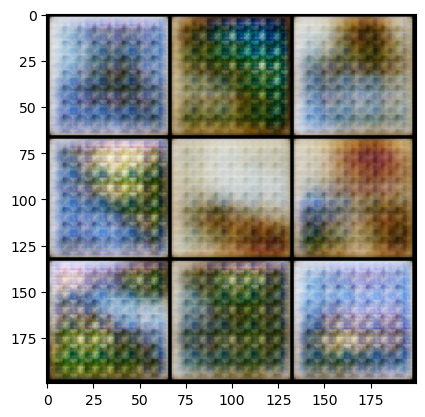

Epoch [81/100] Batch 0/6                 Loss D: 0.5351, loss G: 1.5217


KeyboardInterrupt: 

In [17]:
from torch.utils.tensorboard import SummaryWriter

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
    if epoch % 10 == 0:
        torch.save(gen.state_dict(), f"gen_{epoch}.pt")
        torch.save(disc.state_dict(), f"disc_{epoch}.pt")
        view_sample(fake)


In [ ]:
view_sample(fake)